In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [ ]:
def cargar_datos_csv(ruta, columnas_requeridas):
    """
    Carga un archivo CSV y valida que contenga las columnas requeridas.
    Devuelve un DataFrame filtrado o vacío si hay error.
    """
    if not os.path.exists(ruta):
        print(f"No se encontró el archivo {ruta}.")
        return pd.DataFrame()
    df = pd.read_csv(ruta)
    if not all(col in df.columns for col in columnas_requeridas):
        print(f"El archivo {ruta} no contiene todas las columnas requeridas: {columnas_requeridas}")
        return pd.DataFrame()
    print(f"Se han cargado {len(df)} filas del archivo {ruta}.")
    return df[columnas_requeridas]

archivo = 'data/SP1.csv'
desired_columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']
df = cargar_datos_csv(archivo, desired_columns)
df_original = df.copy()

No se encontró el archivo F-tbol-Club-Barcelona\data\SP1.csv.


<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
C:\Users\msarm\AppData\Local\Temp\ipykernel_2748\2629739810.py:19: SyntaxWarning: invalid escape sequence '\d'
  archivo = 'F-tbol-Club-Barcelona\data\SP1.csv'


In [7]:
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,15/08/2024,Ath Bilbao,Getafe,1,1,D
1,15/08/2024,Betis,Girona,1,1,D
2,16/08/2024,Celta,Alaves,2,1,H
3,16/08/2024,Las Palmas,Sevilla,2,2,D
4,17/08/2024,Osasuna,Leganes,1,1,D
...,...,...,...,...,...,...
365,18/05/2025,Osasuna,Espanol,2,0,H
366,18/05/2025,Sevilla,Real Madrid,0,2,A
367,18/05/2025,Sociedad,Girona,3,2,H
368,18/05/2025,Valencia,Ath Bilbao,0,1,A


In [8]:
def procesar_fechas(df, columna_fecha="Date"):
    """
    Convierte la columna de fecha a datetime y agrega columnas de año, mes y día.
    """
    df = df.copy()
    df[columna_fecha] = pd.to_datetime(df[columna_fecha], format='mixed', dayfirst=True, errors='coerce')
    df["Year"] = df[columna_fecha].dt.year
    df["Month"] = df[columna_fecha].dt.month
    df["Day"] = df[columna_fecha].dt.day
    print(f"Se han procesado las fechas, se han agregado las columnas: {columna_fecha}, Year, Month, Day.")
    if df[columna_fecha].isnull().any():
        print("Algunas fechas no se pudieron convertir, se han establecido como NaT.")
    else:
        print("Todas las fechas se han convertido correctamente.")
    return df

df = procesar_fechas(df)

Se han procesado las fechas, se han agregado las columnas: Date, Year, Month, Day.
Todas las fechas se han convertido correctamente.


In [9]:
def filtrar_por_equipo(df, equipo, col_local="HomeTeam", col_visitante="AwayTeam"):
    """
    Filtra el DataFrame para incluir solo los partidos donde participa el equipo indicado.
    """
    df_filtrado = df[(df[col_local] == equipo) | (df[col_visitante] == equipo)].copy()
    print(f"Se han filtrado {len(df_filtrado)} partidos para el equipo {equipo}.")
    if df_filtrado.empty:
        print(f"No se encontraron partidos para el equipo {equipo}.")
    else:
        print(f"Partidos filtrados para el equipo {equipo}:")
        print(df_filtrado)
    return df_filtrado

chosen_team = "Barcelona"
df = filtrar_por_equipo(df, chosen_team)

Se han filtrado 37 partidos para el equipo Barcelona.
Partidos filtrados para el equipo Barcelona:
          Date     HomeTeam     AwayTeam  FTHG  FTAG FTR  Year  Month  Day
5   2024-08-17     Valencia    Barcelona     1     2   A  2024      8   17
13  2024-08-24    Barcelona   Ath Bilbao     2     1   H  2024      8   24
22  2024-08-27    Vallecano    Barcelona     1     2   A  2024      8   27
29  2024-08-31    Barcelona   Valladolid     7     0   H  2024      8   31
45  2024-09-15       Girona    Barcelona     1     4   A  2024      9   15
59  2024-09-22   Villarreal    Barcelona     1     5   A  2024      9   22
66  2024-09-25    Barcelona       Getafe     1     0   H  2024      9   25
74  2024-09-28      Osasuna    Barcelona     4     2   H  2024      9   28
87  2024-10-06       Alaves    Barcelona     0     3   A  2024     10    6
98  2024-10-20    Barcelona      Sevilla     5     1   H  2024     10   20
104 2024-10-26  Real Madrid    Barcelona     0     4   A  2024     10   26
1

In [10]:
def calcular_puntos(df, equipo, col_local="HomeTeam", col_visitante="AwayTeam", col_resultado="FTR"):
    """
    Añade una columna 'Points' al DataFrame según el resultado y el equipo seleccionado.
    """
    def puntos(row):
        if row[col_resultado] == "H":
            return 3 if row[col_local] == equipo else 0
        elif row[col_resultado] == "A":
            return 3 if row[col_visitante] == equipo else 0
        elif row[col_resultado] == "D":
            return 1 if row[col_local] == equipo or row[col_visitante] == equipo else 0
        else:
            return 0
    df = df.copy()
    df["Points"] = df.apply(puntos, axis=1)
    return df

df = calcular_puntos(df, chosen_team)

In [11]:
def calcular_promedio_puntos_mensual(df, col_mes="Month", col_puntos="Points"):
    """
    Calcula el promedio de puntos por mes y asegura que todos los meses estén presentes.
    Devuelve un DataFrame ordenado con los nombres de los meses en español.
    """
    month_mapping = {
        1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril",
        5: "Mayo", 6: "Junio", 7: "Julio", 8: "Agosto",
        9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
    }
    
    # DataFrame base con todos los meses
    todos_los_meses = pd.DataFrame({col_mes: list(month_mapping.keys())})
    # Promedio de puntos por mes
    monthly_avg = df.groupby([col_mes])[col_puntos].mean().reset_index()
    # Unir para asegurar que todos los meses estén presentes
    monthly_avg = todos_los_meses.merge(monthly_avg, on=col_mes, how="left")
    # Mapear nombres de meses
    monthly_avg[col_mes] = monthly_avg[col_mes].map(month_mapping)
    # Poner 0 en los meses sin datos
    monthly_avg[col_puntos] = monthly_avg[col_puntos].fillna(0)
    # Ordenar los meses según el diccionario
    orden_meses = [v for k, v in month_mapping.items()]
    monthly_avg[col_mes] = pd.Categorical(monthly_avg[col_mes], categories=orden_meses, ordered=True)
    monthly_avg = monthly_avg.sort_values(col_mes).reset_index(drop=True)
    return monthly_avg


monthly_avg_points = calcular_promedio_puntos_mensual(df)
monthly_avg_points

,Month,Points
0,Enero,2.00
1,Febrero,3.00
2,Marzo,3.00
3,Abril,2.50
4,Mayo,2.25
5,Junio,0.00
6,Julio,0.00
7,Agosto,3.00
8,Septiembre,2.25
9,Octubre,3.00


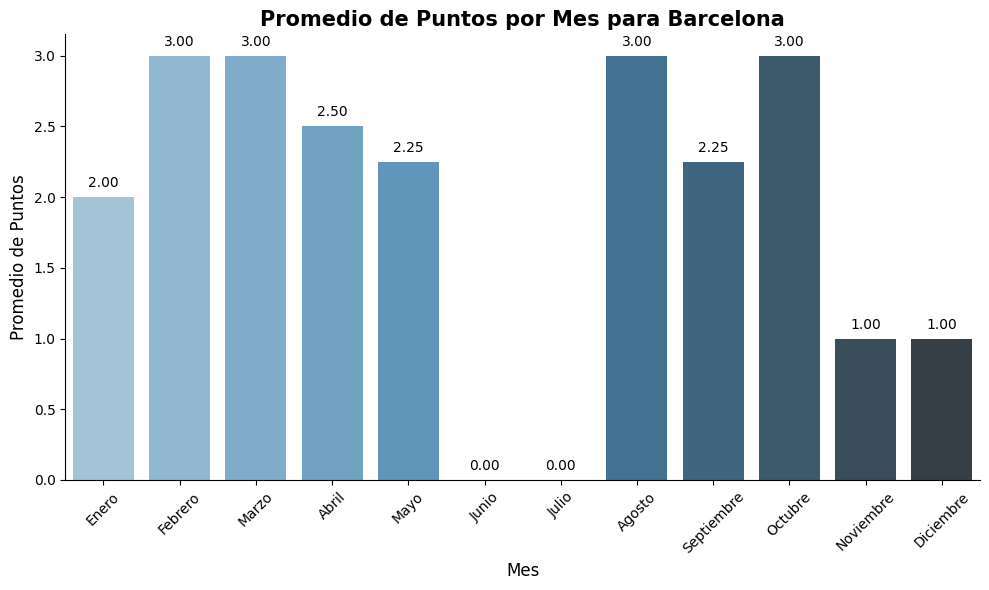

In [12]:
def plot_monthly_avg_points(df, team_name="Equipo"):
    """
    Grafica el promedio de puntos por mes usando seaborn.
    """
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Month", y="Points", data=df, hue="Month", palette="Blues_d", legend=False)
    plt.title(f"Promedio de Puntos por Mes para {team_name}", fontsize=15, fontweight='bold')
    plt.xlabel("Mes", fontsize=12)
    plt.ylabel("Promedio de Puntos", fontsize=12)
    plt.xticks(rotation=45)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', 
                    xytext=(0, 5), textcoords='offset points')
    sns.despine()
    plt.tight_layout()
    plt.show()
    
if 'monthly_avg_points' in locals():
    plot_monthly_avg_points(monthly_avg_points, chosen_team)
else:
    print("monthly_avg_points no está definido. Ejecute la celda correspondiente primero.")

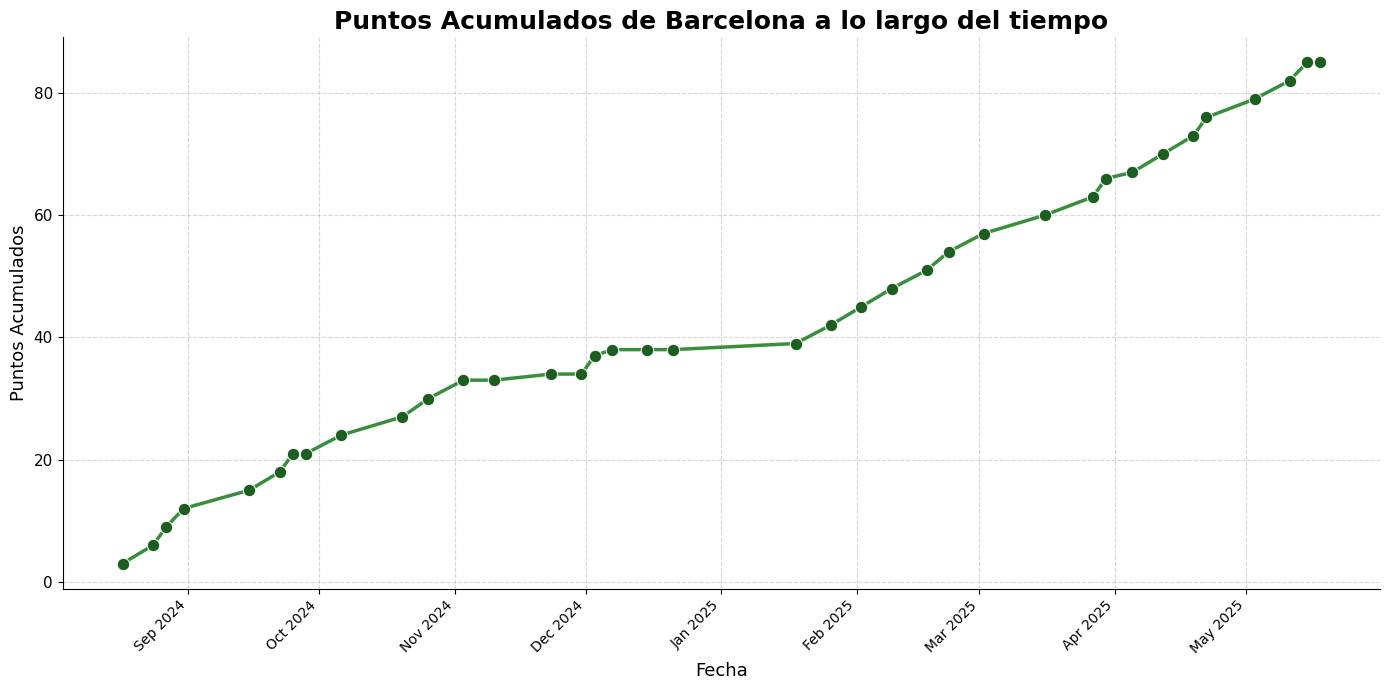

In [ ]:
def plot_puntos_acumulados(df, team_name="Equipo"):
    """
    Grafica la evolución de puntos acumulados por fecha para el equipo seleccionado.
    """

    df_sorted = df.sort_values("Date").reset_index(drop=True)
    df_sorted["Puntos Acumulados"] = df_sorted["Points"].cumsum()

    plt.figure(figsize=(14, 7))
    ax = sns.lineplot(
        x="Date",
        y="Puntos Acumulados",
        data=df_sorted,
        marker='o',
        color='#388e3c',
        linewidth=2.5,
        markersize=7
    )
    sns.scatterplot(
        x="Date",
        y="Puntos Acumulados",
        data=df_sorted,
        color='#1b5e20',
        s=80,
        zorder=3
    )
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.title(f"Puntos Acumulados de {team_name} a lo largo del tiempo", fontsize=18, fontweight='bold')
    plt.xlabel("Fecha", fontsize=13)
    plt.ylabel("Puntos Acumulados", fontsize=13)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_puntos_acumulados(df, team_name=chosen_team)

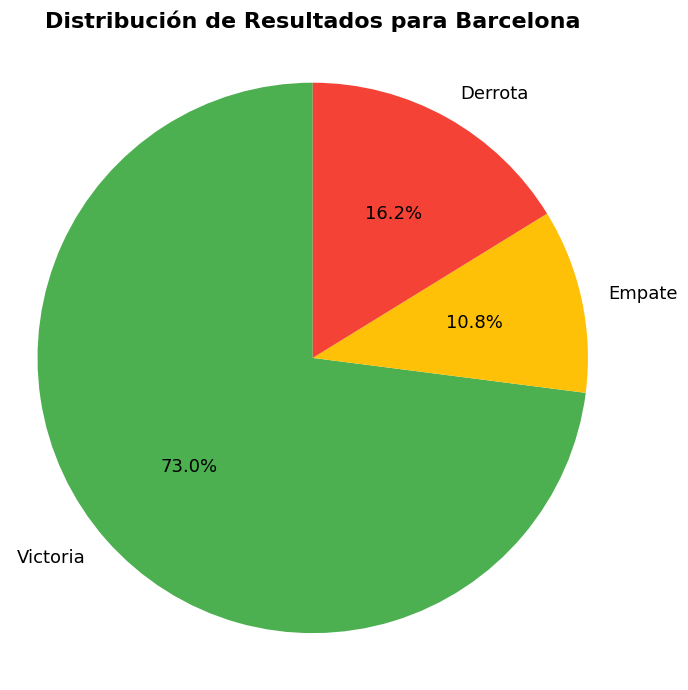

In [ ]:
def calcular_resultados_equipo(df, equipo, col_local="HomeTeam", col_visitante="AwayTeam", col_resultado="FTR"):
    """
    Calcula la cantidad de victorias, empates y derrotas para un equipo.
    Devuelve un DataFrame listo para graficar.
    """
    resultados = {
        "Victoria": ((df[col_local] == equipo) & (df[col_resultado] == "H")).sum() +
                    ((df[col_visitante] == equipo) & (df[col_resultado] == "A")).sum(),
        "Empate": ((df[col_resultado] == "D") & ((df[col_local] == equipo) | (df[col_visitante] == equipo))).sum(),
        "Derrota": ((df[col_local] == equipo) & (df[col_resultado] == "A")).sum() +
                ((df[col_visitante] == equipo) & (df[col_resultado] == "H")).sum()
    }
    return pd.DataFrame({
        "Resultado": list(resultados.keys()),
        "Cantidad": list(resultados.values())
    })

def plot_resultados_equipo_pie(resultados_df, team_name="Equipo"):
    """
    Grafica la distribución de resultados (victorias, empates, derrotas) para un equipo en formato circular (pie chart).
    """
    colores = ["#4CAF50", "#FFC107", "#F44336"]
    plt.figure(figsize=(7, 7))
    plt.pie(
        resultados_df["Cantidad"],
        labels=resultados_df["Resultado"],
        autopct='%1.1f%%',
        startangle=90,
        colors=colores,
        textprops={'fontsize': 13}
    )
    plt.title(f"Distribución de Resultados para {team_name}", fontsize=16, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

resultados_df = calcular_resultados_equipo(df, chosen_team)
plot_resultados_equipo_pie(resultados_df, team_name=chosen_team)

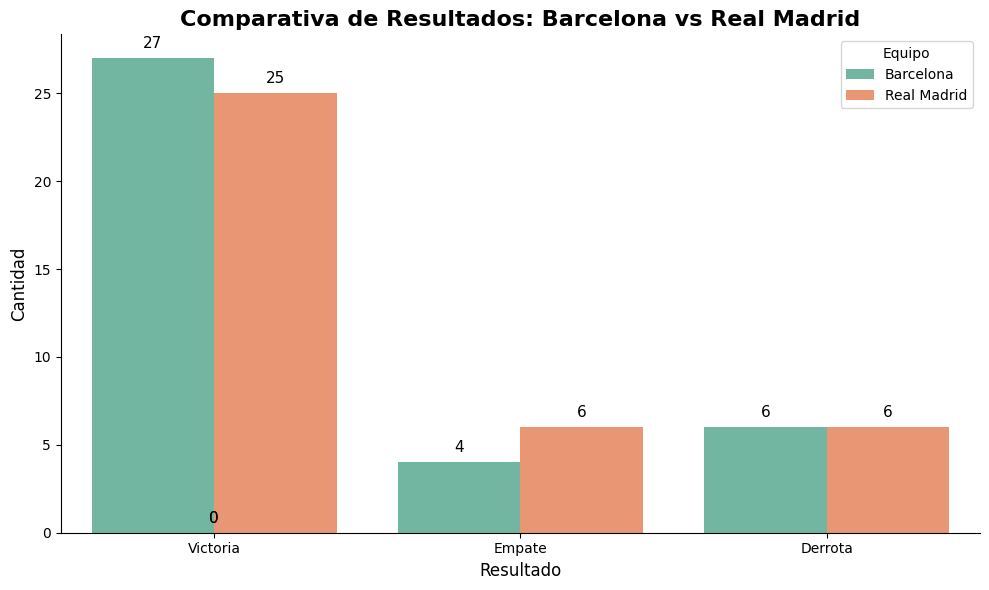

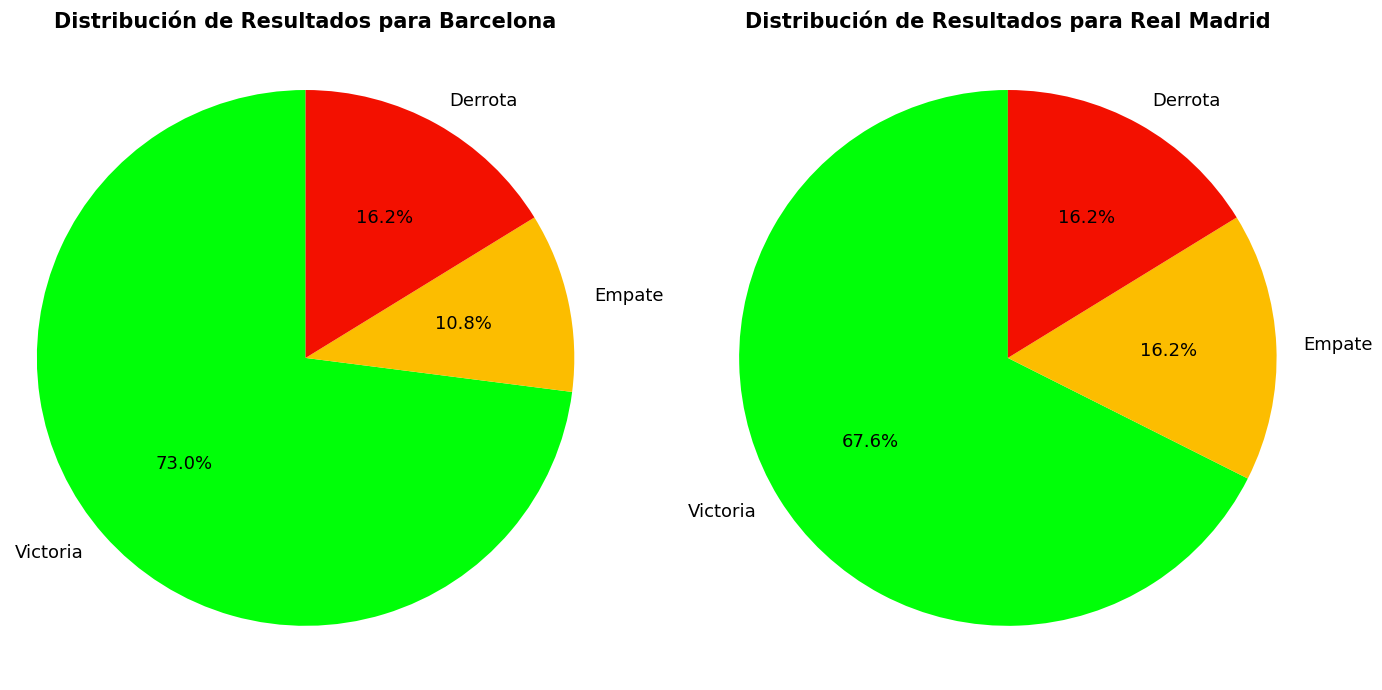

DataFrame guardado en data/SP1_procesado.csv


In [16]:
def comparar_resultados_equipos(
    df, equipo1, equipo2, col_local="HomeTeam", col_visitante="AwayTeam", col_resultado="FTR"
):
    """
    Compara la distribución de resultados (victorias, empates, derrotas) entre dos equipos y muestra:
    - Gráfica comparativa de barras
    - Gráficas circulares individuales para cada equipo
    Incluye validación de nombres y limpieza de espacios.
    """
    # Limpieza de espacios y normalización de nombres
    df = df.copy()
    df[col_local] = df[col_local].astype(str).str.strip()
    df[col_visitante] = df[col_visitante].astype(str).str.strip()
    equipo1 = equipo1.strip()
    equipo2 = equipo2.strip()

    # Validación de nombres de equipos
    equipos_disponibles = set(df[col_local].unique()).union(set(df[col_visitante].unique()))
    if equipo1 not in equipos_disponibles or equipo2 not in equipos_disponibles:
        print("Error: Uno o ambos equipos no existen en el DataFrame.")
        print("Equipos disponibles:", sorted(equipos_disponibles))
        return

    def calcular_resultados(df, equipo):
        victorias = ((df[col_local] == equipo) & (df[col_resultado] == "H")).sum() + \
                    ((df[col_visitante] == equipo) & (df[col_resultado] == "A")).sum()
        empates = ((df[col_resultado] == "D") & ((df[col_local] == equipo) | (df[col_visitante] == equipo))).sum()
        derrotas = ((df[col_local] == equipo) & (df[col_resultado] == "A")).sum() + \
                ((df[col_visitante] == equipo) & (df[col_resultado] == "H")).sum()
        return {"Victoria": victorias, "Empate": empates, "Derrota": derrotas}

    resultados1 = calcular_resultados(df, equipo1)
    resultados2 = calcular_resultados(df, equipo2)

    resultados_df = pd.DataFrame({
        "Resultado": ["Victoria", "Empate", "Derrota"],
        equipo1: [resultados1["Victoria"], resultados1["Empate"], resultados1["Derrota"]],
        equipo2: [resultados2["Victoria"], resultados2["Empate"], resultados2["Derrota"]]
    })
    resultados_df_melt = resultados_df.melt(id_vars="Resultado", var_name="Equipo", value_name="Cantidad")

    # Gráfica de barras comparativa
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Resultado", y="Cantidad", hue="Equipo", data=resultados_df_melt, palette="Set2")
    plt.title(f"Comparativa de Resultados: {equipo1} vs {equipo2}", fontsize=16, fontweight='bold')
    plt.xlabel("Resultado", fontsize=12)
    plt.ylabel("Cantidad", fontsize=12)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=11, color='black',
                    xytext=(0, 5), textcoords='offset points')
    plt.legend(title="Equipo")
    sns.despine()
    plt.tight_layout()
    plt.show()

    # Gráficas circulares individuales
    colores = ["#00FF08", "#FCBD00", "#F31000"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    for i, (res, nombre) in enumerate(zip([resultados1, resultados2], [equipo1, equipo2])):
        datos = list(res.values())
        axs[i].pie(
            datos,
            labels=["Victoria", "Empate", "Derrota"],
            autopct='%1.1f%%',
            startangle=90,
            colors=colores,
            textprops={'fontsize': 13}
        )
        axs[i].set_title(f"Distribución de Resultados para {nombre}", fontsize=15, fontweight='bold')
        axs[i].axis('equal')
    plt.tight_layout()
    plt.show()
    
comparar_resultados_equipos(df_original, "Barcelona", "Real Madrid")
def guardar_dataframe(df, ruta_salida):
    """
    Guarda el DataFrame en un archivo CSV.
    """
    df.to_csv(ruta_salida, index=False)
    print(f"DataFrame guardado en {ruta_salida}")

guardar_dataframe(df, "data/SP1_procesado.csv")